# Valencia Airbnb listings Analysis
## by Eduardo Burgoa


## Businesse Understanding
The purpose of the analysis is to gain more understanding of the characteristics of Airbnb offer in the city of Valencia. I am focusing on answering the following questions:

- What neighbourhoods have highest average Airbnb price listings in the city of Valencia?
- What neighbourhoods have greater proportion of listings with multiple listing-owners?
- What factors are related to price of Airbnb in house listings?



## Data understanding 
This dataset includes 7233 Airbnb apartments in the city of Valencia updated on September 30th of 2019. This dataset has been colleted by Murray Cox from public information in Airbnb web page anonimazing any personal data. The purpose of this data collection work is adding data to key metrics so anyone can analyse how Airbnb is being used to compete with the residential housing market.

Let's explore the variables included in the dataset.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from utils import coef_weights, find_optimal_lm_mod
%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# Import Data
df_listings = pd.read_csv('listings.csv')
df_neighbourhoods = pd.read_csv('neighbourhoods.csv')


In [3]:
print("Listings")
print(df_listings.info(max_cols=106))
print("Neighbourhoods")
print(df_neighbourhoods.info())

Listings
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7233 entries, 0 to 7232
Data columns (total 106 columns):
id                                              7233 non-null int64
listing_url                                     7233 non-null object
scrape_id                                       7233 non-null int64
last_scraped                                    7233 non-null object
name                                            7233 non-null object
summary                                         6897 non-null object
space                                           5412 non-null object
description                                     7041 non-null object
experiences_offered                             7233 non-null object
neighborhood_overview                           4874 non-null object
notes                                           3328 non-null object
transit                                         4523 non-null object
access                                          3702 non-

In [4]:
df_listings[['name', 'space','experiences_offered', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'price', 'monthly_price','host_total_listings_count']].head()

,name,space,experiences_offered,neighbourhood_cleansed,neighbourhood_group_cleansed,price,monthly_price,host_total_listings_count
0,VALENCIA HISTORIC HOUSE 50M BEACH,1920 HISTORIC house passed down by generations...,none,LA MALVA-ROSA,POBLATS MARITIMS,$150.00,NaN,3.0
1,Valencia: El Saler Beach and Albufera Lake,"Near to the beach, near to the city. Come with...",none,EL SALER,POBLATS DEL SUD,$100.00,"$1,000.00",1.0
2,beautiful apartment wifi,Hello everybody and thank you for your interes...,none,MORVEDRE,LA SAIDIA,$45.00,$870.00,2.0
3,Delight in city center,Hello everybody and thank you very much for sh...,none,LA SEU,CIUTAT VELLA,$100.00,$700.00,1.0
4,Modern and bright Duplex 3 Bedrooms Center Wi-Fi,Located right in the Historical Centre you can...,none,EL CARME,CIUTAT VELLA,$134.00,NaN,6.0


In [5]:
df_neighbourhoods.head()

,neighbourhood_group,neighbourhood
0,ALGIROS,CIUTAT JARDI
1,ALGIROS,LA CARRASCA
2,ALGIROS,L'AMISTAT
3,ALGIROS,LA VEGA BAIXA
4,ALGIROS,L'ILLA PERDUDA


The only data we need to answer our questions of interest is `listings.csv` as neighbourhoods names are also included in it.

## Data Preparation

### Quality issues
- `price` and `extra_people` are strings and should be numeric.

- Boolean variables as `host_is_superhost`, `host_identity_verified`, `has_availability`, `requires_license`, `calendar_updated`, `host_has_profile_pic`, `is_location_exact`, `instant_bookable`, `is_business_travel_ready`, `require_guest_phone_verification`, `require_guest_profile_picture` are encoded as string and should be boolean.

- There are some columns with less than 10% of values or no values at all as: `host_acceptance_rate`, `square_feet`, `thumbnail_url`, `medium_url`, `xl_picture_url`, `jurisdiction_names`, `montly_price`, `weekly_price`.

- There are several columns that are free text and have missing values as: `summary`, `space`,  `description`, `neighborhood_overview`, `notes`, `transit`, `access`, `interaction`, `house_rules`, `host_neighbourhood`, `host_location`, `host_about`, `neighbourhood`, `first_review`, `last_review`, `license`, `state`, `zipcode`.

- There are other categorical or numeric columns also with missing values , `host_response_time`, `host_response_rate`, `review_scores_rating`, `review_scores_accuracy`, `review_scores_cleanliness`, `review_scores_checkin`, `review_scores_communication`, `review_scores_location`, `review_scores_value`,  `reviews_per_month`, `security_deposit`, `cleaning_fee`

### Preparation for modeling
- We have several categorical variables. We should convert them in order to include them in the model.


#### Cleaning Price

In [6]:
def cleaning_prices(df, variable):
    df[variable] = df[variable].str.replace('$', '')
    df[variable] = df[variable].str.replace(',', '')
    df[variable] = pd.to_numeric(df[variable])
    return df

price_list = ['price', 'extra_people', 'cleaning_fee']


for variable in price_list:
    df_listings = cleaning_prices(df_listings, variable)


In [7]:
df_listings['host_response_rate'] = df_listings['host_response_rate'].str.replace('%', '')
df_listings['host_response_rate'] = pd.to_numeric(df_listings['host_response_rate'])/100

#### Cleaning Boolean variables

In [8]:
def cleaning_boolean(df, variable):
    df.loc[df[variable] == 'f', variable] = False
    df.loc[df[variable] == 't', variable] = True
    df[variable] = df[variable].astype('bool')

    return df

boolean_list = ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic', 'has_availability', 
                'requires_license', 'calendar_updated', 'is_location_exact', 'instant_bookable', 
                'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture']

for variable in boolean_list:
    df_listings = cleaning_boolean(df_listings, variable)


#### Cleaning Empty values

In [9]:
# Before droping data we'll create a new data frame
df_clean = df_listings.copy()

# We drop unneded columns
df_clean.drop(columns=['id', 'scrape_id', 'host_id',  'latitude', 'longitude', 'host_acceptance_rate', 
                       'host_thumbnail_url', 'host_picture_url', 'square_feet', 'thumbnail_url', 'medium_url', 
                       'xl_picture_url', 'host_verifications', 'street', 'jurisdiction_names', 'monthly_price', 
                       'weekly_price', 'summary', 'space',  'description', 'neighborhood_overview', 'notes', 
                       'transit', 'access', 'interaction', 'house_rules', 'host_neighbourhood', 'host_location', 
                       'host_about', 'neighbourhood', 'first_review', 'last_review', 'license', 'security_deposit', 
                       'state', 'zipcode', 'last_scraped', 'calendar_last_scraped', 'smart_location', 
                       'listing_url', 'host_url', 'picture_url', 'city', 'country_code', 'city', 'host_since', 
                       'name', 'amenities', 'host_name'], inplace=True)



In [10]:
# Fill numeric columns with the mean
num_cols = df_clean.select_dtypes(include=['float', 'int']).columns
for col in num_cols:
    df_clean[col].fillna((df_clean[col].mean()), inplace=True)

In [20]:
# Fill categorical columns with the mode
cat_cols = df_clean.select_dtypes(include=['object']).columns
for col in cat_cols:
    df_clean[col].fillna((df_clean[col].mode()[0]), inplace=True)

In [21]:
# We drop rows with missing values
df_clean.dropna(axis=0, inplace=True)

# We check againg if any column has missing values
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7233 entries, 0 to 7232
Data columns (total 58 columns):
experiences_offered                             7233 non-null object
host_response_time                              7233 non-null object
host_response_rate                              7233 non-null float64
host_is_superhost                               7233 non-null bool
host_listings_count                             7233 non-null float64
host_total_listings_count                       7233 non-null float64
host_has_profile_pic                            7233 non-null bool
host_identity_verified                          7233 non-null bool
neighbourhood_cleansed                          7233 non-null object
neighbourhood_group_cleansed                    7233 non-null object
market                                          7233 non-null object
country                                         7233 non-null object
is_location_exact                               7233 non-null bool
p

## Numerical variables

Numerical variables after cleaning should be ready for the model.

In [24]:
num_df = df_clean.select_dtypes(include=['int64', 'float64', 'bool'])
num_cols_lst = num_df.columns
num_cols_lst= num_cols_lst.drop('price')

In [25]:
df_num_cols = df_clean[num_cols_lst]

#### Categorical variables

Categorical variables should be converted to numeric.

In [26]:
cat_df = df_clean.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns
cat_cols_lst

Index(['experiences_offered', 'host_response_time', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'market', 'country', 'property_type',
       'room_type', 'bed_type', 'cancellation_policy'],
      dtype='object')

In [27]:
df_cat_cols = df_clean[cat_cols_lst]
for var in  cat_cols_lst:
    # for each cat add dummy var, drop original column
    df_cat_cols = pd.concat([df_cat_cols.drop(var, axis=1), pd.get_dummies(df_cat_cols[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [28]:
df_cat_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7233 entries, 0 to 7232
Columns: 144 entries, host_response_time_within a day to cancellation_policy_super_strict_60
dtypes: uint8(144)
memory usage: 1.0 MB


In [29]:
df_ready = pd.concat([df_num_cols, df_cat_cols], axis=1)

## Descriptive Satistics

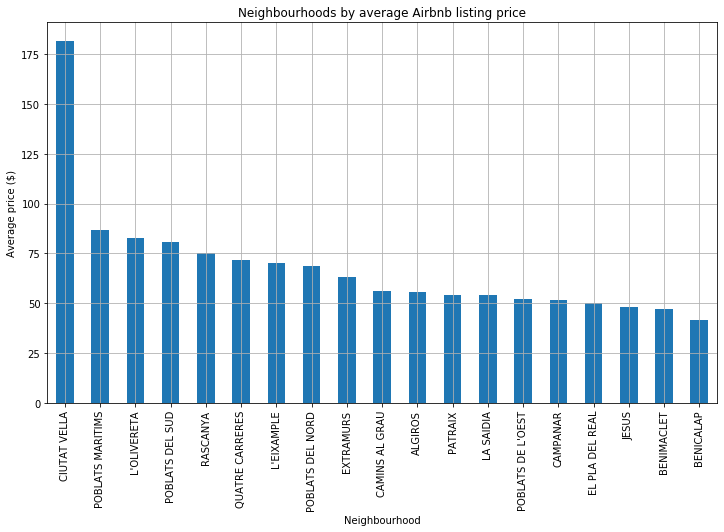

In [30]:
neigbourhoods_by_price = df_listings.groupby('neighbourhood_group_cleansed')['price'].mean()
neigbourhoods_by_price = neigbourhoods_by_price.nlargest(len(neigbourhoods_by_price))

neigbourhoods_by_price.plot('bar', figsize=(12,7))
plt.title('Neighbourhoods by average Airbnb listing price')
plt.xlabel('Neighbourhood')
plt.ylabel('Average price ($)')
plt.grid();

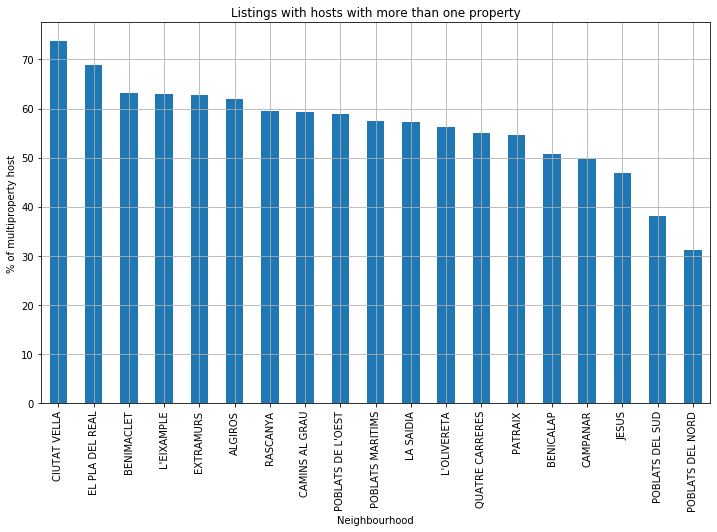

In [31]:
totals_by_neibourhood = df_listings.groupby('neighbourhood_group_cleansed')['id'].count()
multiproperty_by_neighbourhood = df_listings.query('host_total_listings_count >= 2').groupby('neighbourhood_group_cleansed')['id'].count()
proportion = multiproperty_by_neighbourhood/totals_by_neibourhood*100

proportion = proportion.nlargest(len(proportion))

proportion.plot('bar', figsize=(12,7))
plt.title('Listings with hosts with more than one property')
plt.xlabel('Neighbourhood')
plt.ylabel('% of multiproperty host')
plt.grid();

## Model

In [32]:
X = df_ready
y = df_clean['price']

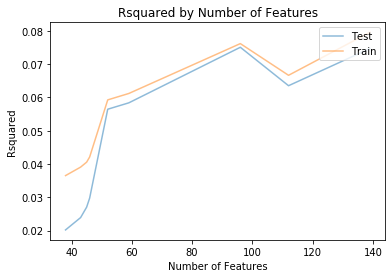

In [34]:
#cutoffs here pertains to the number of missing values allowed in the used columns.
#Therefore, lower values for the cutoff provides more predictors in the model.
cutoffs = [7000, 5000, 3500, 2500, 1000, 500, 100, 50, 25]

r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs, test_size =.4)

## Evaluation

In [35]:
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model is {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model is 0.07505600360288411 on 2894 values.'

In [36]:
coef_df = coef_weights(lm_model, X_train)
coef_df.head(25)

,est_int,coefs,abs_coefs
22,calendar_updated,-1.057169e+15,1.057169e+15
37,requires_license,-8.509468e+14,8.509468e+14
61,neighbourhood_cleansed_LA ROQUETA,3.956492e+14,3.956492e+14
52,neighbourhood_cleansed_EL BOTANIC,3.956492e+14,3.956492e+14
48,neighbourhood_cleansed_ARRANCAPINS,3.956492e+14,3.956492e+14
60,neighbourhood_cleansed_LA PETXINA,3.956492e+14,3.956492e+14
77,neighbourhood_group_cleansed_EXTRAMURS,-3.956492e+14,3.956492e+14
23,has_availability,-3.598683e+14,3.598683e+14
75,neighbourhood_group_cleansed_CIUTAT VELLA,1.056058e+14,1.056058e+14
56,neighbourhood_cleansed_EL PILAR,-1.056058e+14,1.056058e+14


## Deployment

This analysis will be used soon in a blog post in order to share this findings with the world